# DS-поток, весна 2025
## Задание ADL.1


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарииь к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Баллы за задание**  
Задача 1 &mdash; **90 баллов**  
Задача 2 &mdash; **30 баллов**

Всего &mdash; **120 баллов**  

In [1]:
# Bot check

# HW_ID: ds_adl1
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from PIL import Image
from IPython.display import display
from pathlib import Path
from tqdm.auto import tqdm
from functools import lru_cache
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F

from transformers import EfficientNetForImageClassification, EfficientNetImageProcessor
from transformers import SwinForImageClassification

from tqdm.notebook import tqdm
import time
import gc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Задача 1 &mdash; обучение моделей на разном объеме данных

В этой задаче нужно определить зависимость качества модели от размера обучающих данных и сравнить между собой сверточную и трансформерную модель.

В качестве данных будем использовать [датасет](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset) с фотографиями одежды и аксессуаров. В качестве лейблов классификации используем поле `subCategory` в `styles`.

### 1. Подготовка данных



Для начала определим пути до изображений и таблицы с описанием товаров.

In [3]:
root = Path('/kaggle/input/fashion-product-images-dataset/fashion-dataset')
images_root = root / 'images'
styles_path = root / 'styles.csv'

Считаем таблицу с описанием товаров. Заметим, что нас интересует только одна колонка &mdash; `subCategory`.

In [4]:
styles_df = pd.read_csv(styles_path, usecols=['id', 'subCategory'], index_col='id')
styles_df.head()

subCategory
id               
15970     Topwear
39386  Bottomwear
59263     Watches
21379  Bottomwear
53759     Topwear

Заметим, что количество изображений близко, но не точно равно количеству товаров в таблице с описанием.

In [5]:
len(list(images_root.iterdir())), len(styles_df)

(44441, 44446)

При этом идентификаторы изображений уникальны, а среди идентификаторов в таблице с описанием есть несколько повторений.

In [6]:
ids1 = [int(path.name.split('.')[0]) for path in images_root.iterdir()]
ids2 = styles_df.index.tolist()
print(len(set(ids1) & set(ids2)) == len(ids1))

True


Посчитаем количество различных лейблов.

In [7]:
labels = styles_df.loc[ids1]['subCategory'].values
val, cnt = np.unique(labels, return_counts=True)
cnt

array([  143,   106,  3055,    12,     4,   811,  2693,   108,   478,
          43,  1073,   915,  1012,   104,    20,    19,   293,     1,
        1808,  1080,   527,   470,   307,    38,   329,     6,   963,
         427,   118,    24,  7344,    69,    77,   698,     3,    21,
          90,   258, 15401,     6,     1,   933,  2542,     7,     4])

Отсечем все классы, которые встречаются слишком редко &mdash; меньше 100 экземпляров. Для них оставим соответствующие идентификаторы. Визуализируем некоторые картинки.

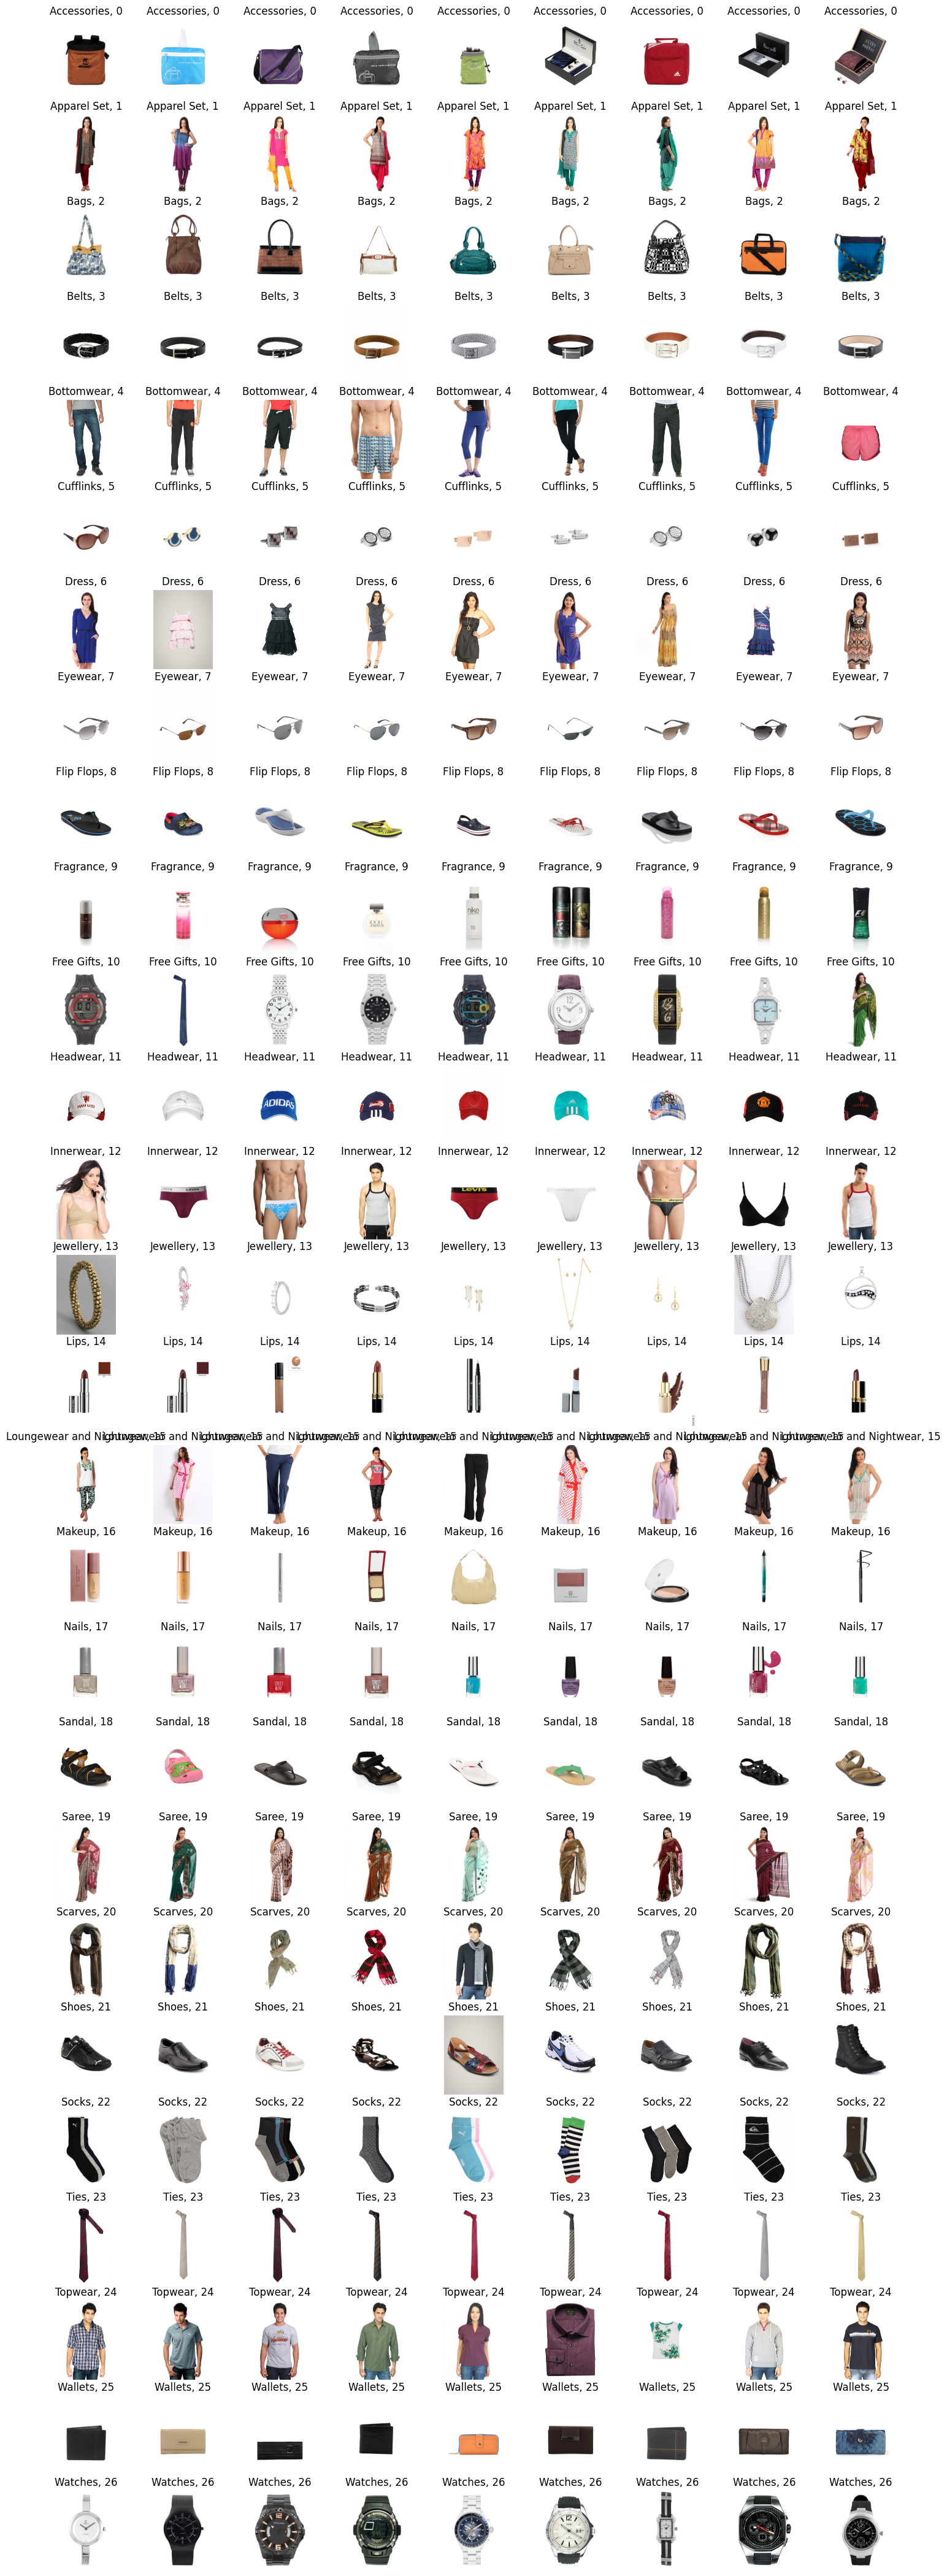

In [8]:
labels_unique = val[cnt >= 100]
len(labels_unique)

fig, axs = plt.subplots(27, 9, figsize=(18, 54))
for i, label in enumerate(labels_unique):
    ids = styles_df[styles_df['subCategory'] == label].index[:9]
    for j, id in enumerate(ids):
        image = Image.open(images_root / f'{id}.jpg')
        axs[i, j].imshow(image)
        axs[i, j].set_title(f"{label}, {i}")
        axs[i, j].axis('off')

Можно заметить, что есть классы товаров, которые могут включать в себя другие классы товаров.

In [9]:
labels = styles_df["subCategory"][styles_df["subCategory"].isin(labels_unique)]
val, cnt = np.unique(labels, return_counts=True)
for v, c in zip(val, cnt):
    print(v, c)

Accessories 143
Apparel Set 106
Bags 3055
Belts 811
Bottomwear 2694
Cufflinks 108
Dress 478
Eyewear 1073
Flip Flops 915
Fragrance 1012
Free Gifts 104
Headwear 293
Innerwear 1808
Jewellery 1080
Lips 527
Loungewear and Nightwear 470
Makeup 307
Nails 329
Sandal 963
Saree 427
Scarves 118
Shoes 7344
Socks 698
Ties 258
Topwear 15405
Wallets 933
Watches 2542


Категория `Accessories` довольно общая, но при этом немногочисленная, ее можно исключить. То же касается категории `Free Gifts`. Категории `Flip Flops` и `Sandal` значительно пересекаются друг с другом, поэтому их лучше объединить.

In [10]:
labels_unique = labels_unique[~np.isin(labels_unique, ["Accessories",  "Free Gifts", "Flip Flops"])]
styles_df[styles_df["subCategory"] == "Flip Flops"] = "Sandal"
styles_df = styles_df[styles_df["subCategory"].isin(labels_unique)]
num_classes, num_ids = len(labels_unique), len(styles_df.index)
num_classes, num_ids

(24, 43754)

Составим карту отображения лейблов в классы.

In [11]:
label2class = {label: i for i, label in enumerate(labels_unique)}
label2class

{'Apparel Set': 0,
 'Bags': 1,
 'Belts': 2,
 'Bottomwear': 3,
 'Cufflinks': 4,
 'Dress': 5,
 'Eyewear': 6,
 'Fragrance': 7,
 'Headwear': 8,
 'Innerwear': 9,
 'Jewellery': 10,
 'Lips': 11,
 'Loungewear and Nightwear': 12,
 'Makeup': 13,
 'Nails': 14,
 'Sandal': 15,
 'Saree': 16,
 'Scarves': 17,
 'Shoes': 18,
 'Socks': 19,
 'Ties': 20,
 'Topwear': 21,
 'Wallets': 22,
 'Watches': 23}

Проверим, для всех ли идентификаторов из таблицы стилей есть соответствующие изображения. Удалим идентификаторы, для которых изображения не нашлись.

In [12]:
not_found_ids = []
for id in tqdm(styles_df.index):
    if not (images_root / f'{id}.jpg').exists():
        not_found_ids.append(id)
styles_df = styles_df[~styles_df.index.isin(not_found_ids)]

# Проверим, что в таблице остались только уникальные идентификаторы.
assert len(styles_df.index) == len(np.unique(styles_df.index))

  0%|          | 0/43754 [00:00<?, ?it/s]

Реализуем класс для работы с данными.

In [13]:
class StylesDataset(Dataset):
    def __init__(self, images_root, styles_df, label2class, ids, transform):
        self.images_root = images_root
        self.styles_df = styles_df
        self.label2class = label2class
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    @lru_cache(maxsize=400)
    def __getitem__(self, i):
        id = self.ids[i]
        image = Image.open(self.images_root / f'{id}.jpg')
        image = self.transform(image)
        label = self.styles_df.loc[id, 'subCategory']
        cls = self.label2class[label]
        return image, cls

### 2. Обучение моделей

Модели можно выбрать из [timm](https://github.com/huggingface/pytorch-image-models), [torchvision](https://pytorch.org/vision/stable/models.html) или [huggingface](https://huggingface.co/docs/transformers/index). В качестве сверточной модели можно использовать EfficientNet или более мощную модель. Более мощную модель будем определять по рейтингу top-1 моделей предобученных на ImageNet. Для сравнения моделей можно воспользоваться [рейтингом paperswithcode](https://paperswithcode.com/sota/image-classification-on-imagenet) или соотвествующими результатами в научных статьях, посвященным моделям для классификации изображений. В качестве трансформерной модели можно использовать ViT, DeiT, CeiT, VOLO, SWIN или более мощные модели. Для того, чтобы достигнуть хорошего качества, используйте уже предобученные модели.

*Задача*  &mdash;  для разных обучающих наборов данных: 2000, 8000 снимков и всего набора данных (42749 снимков) посчитайте weighted accuracy (усредненную accuracy по всем классам) для сверточной и трансформерной моделей. На тест выделите 1000 снимков. На большом объеме данных трансформерная модель не должна быть сильно хуже сверточной. На всем датасете обе модели должны пробить порог weighted accuracy равный 0.8.

Возможно, *для улучшения качества трансформера* вам могут помочь:
- [пример](https://keras.io/examples/vision/vit_small_ds/) с построением трансформерной модели на keras, где описываются аугментации, shifted patches, local attention;
- [статья](https://arxiv.org/pdf/2106.03746.pdf), где используют доп. лосс для обучения произвольной трансформерной модели на небольшом объеме данных.

*Правила проведения экспериментов*.
- Для всех экспериментов используйте одинаковый пайплайн семплирования данных &mdash; аугментации, размер батча, метод выбора данных для формирования батча.
- Для экспериментов с одинаковым количеством обучающих данных используйте одинакове число эпох для обучения. 
- Для каждой модели (сверточной и трансформерной) зафиксируйте пайплайн обучения &mdash; саму модель, оптимизатор, learing rate scheduling, регуляризацию весов модели, лоссы.
- Поясните выбор стратегии семплирования данных и пайпайна обучения.

In [14]:
image_size = 224  
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # изменение размера
    transforms.RandomHorizontalFlip(),            # аугментация: случайное отражение
    transforms.RandomRotation(10),                # аугментация: случайный поворот
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # цветовые искажения
    transforms.ToTensor(),
    transforms.Normalize(
        mean=MEAN,  # ImageNet mean
        std=STD    # ImageNet std
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=MEAN,
        std=STD
    ),
])

In [15]:
def get_loaders(images_root = images_root,
                styles_df=styles_df,
                label2class=label2class,
                ids=styles_df.index,
                train_transform=train_transform,
                test_transform=val_transform,
                N=2000,
                batch_size=32,
                num_workers=4):
    
    labels = styles_df.loc[ids, 'subCategory'].map(label2class).values

    train_ids, test_ids = train_test_split(
        ids,
        train_size=N,
        test_size=1000,
        stratify=labels,
        random_state=42
    )

    train_dataset = StylesDataset(images_root, styles_df, label2class, train_ids, train_transform)
    val_dataset = StylesDataset(images_root, styles_df, label2class, test_ids, test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader

In [16]:
def train_model(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, device="cpu", developer_mode=False):
    """
    Обучает модель, используя тренировочный и валидационный лоадеры.
    Сохраняет историю значений лосса и точности на обучении и валидации.
    
    Аргументы:
      model: nn.Module, модель для обучения.
      train_loader: DataLoader для обучения.
      valid_loader: DataLoader для валидации.
      optimizer: оптимизатор.
      loss_fn: функция потерь.
      num_epochs: число эпох.
      device: устройство ("cpu" или "cuda").
      developer_mode: если True, обучение и валидация происходят только на одном батче.
    
    Возвращает:
      history: словарь с ключами 'train_loss', 'valid_loss', 'train_acc', 'valid_acc'.
    """
    model.to(device)
    history = {
        "train_loss": [],
        "valid_loss": [],
        "train_acc": [],
        "valid_acc": []
    }
    
    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0
        
        for i, (images, labels) in enumerate(tqdm(train_loader)):
            if developer_mode and i >= 1:
                break
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(logits, dim=1)
            running_corrects += torch.sum(preds == labels.data)
            total_train += images.size(0)
        
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = running_corrects.double() / total_train
        
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_valid = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(valid_loader)):
                if developer_mode and i >= 1:
                    break
                
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                logits = outputs.logits
                loss = loss_fn(logits, labels)
                running_loss += loss.item() * images.size(0)
                preds = torch.argmax(logits, dim=1)
                running_corrects += torch.sum(preds == labels.data)
                total_valid += images.size(0)
                
        epoch_valid_loss = running_loss / total_valid
        epoch_valid_acc = running_corrects.double() / total_valid
        
        history["train_loss"].append(epoch_train_loss)
        history["valid_loss"].append(epoch_valid_loss)
        history["train_acc"].append(epoch_train_acc.item())
        history["valid_acc"].append(epoch_valid_acc.item())

        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f} - "
              f"Valid loss: {epoch_valid_loss:.4f}, Valid acc: {epoch_valid_acc:.4f} - "
              f"Time: {epoch_time:.2f} sec")
        
    return history


In [17]:
def plot_metrics(model_names, history_list):
    """
    Принимает список имён моделей и список history-словарей, возвращенных из train_model.
    Строит два subplot: один для лоссов (train и valid) и второй для точностей (train и valid)
    
    Аргументы:
      model_names: список строк с именами моделей.
      history_list: список словарей с ключами 'train_loss', 'valid_loss', 'train_acc', 'valid_acc'.
    """
    num_models = len(model_names)
    epochs = len(history_list[0]["train_loss"])
    x = range(1, epochs+1)
    
    plt.figure(figsize=(14, 6))
    
    # Subplot для лоссов
    plt.subplot(1, 2, 1)
    for name, history in zip(model_names, history_list):
        plt.plot(x, history["train_loss"], label=f"{name} Train loss")
        plt.plot(x, history["valid_loss"], linestyle="--", label=f"{name} Valid loss")
    plt.xlabel("Эпохи")
    plt.ylabel("Лосс")
    plt.title("Лосс (train/valid)")
    plt.legend()
    plt.grid(True)
    
    # Subplot для точности
    plt.subplot(1, 2, 2)
    for name, history in zip(model_names, history_list):
        plt.plot(x, history["train_acc"], label=f"{name} Train acc")
        plt.plot(x, history["valid_acc"], linestyle="--", label=f"{name} Valid acc")
    plt.xlabel("Эпохи")
    plt.ylabel("Точность")
    plt.title("Точность (train/valid)")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

1) 2000 снимков

In [18]:
train_loader, valid_loader = get_loaders(N=2000)

Посмотрим, все ли прошло корректно

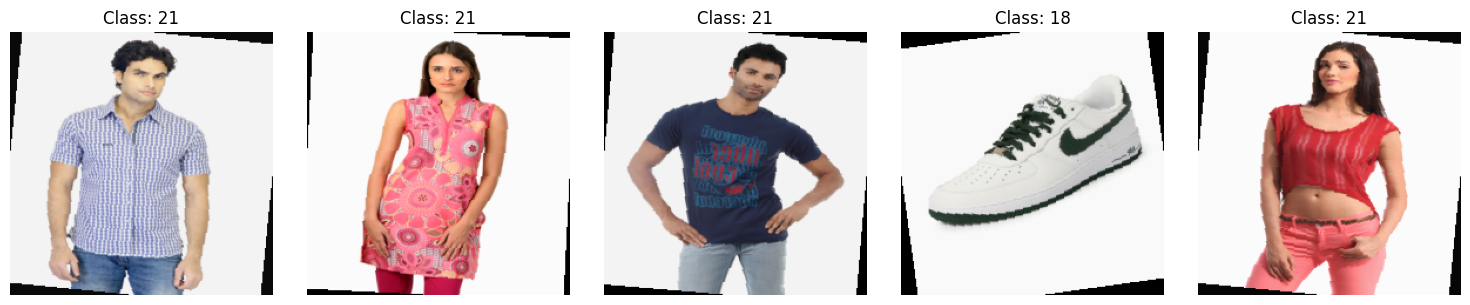

In [19]:
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return img * std + mean

# Получаем первую батч из train_loader
images, labels = next(iter(train_loader))

# Отображаем 5 изображений в строку
plt.figure(figsize=(15, 3))
for i in range(5):
    img = denormalize(images[i], MEAN, STD)  # Обратная нормализация
    img = torch.clamp(img, 0, 1)             # На всякий случай
    img = F.to_pil_image(img)                # Преобразуем обратно в PIL
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Class: {labels[i].item()}')
plt.tight_layout()
plt.show()

Обучим модели

In [20]:
label2class.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [21]:
num_classes = max(label2class.values()) + 1

In [22]:
lr = 1e-4

efficient_model_2000 = EfficientNetForImageClassification.from_pretrained(
    "google/efficientnet-b0",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

optimizer = torch.optim.AdamW(efficient_model_2000.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([24, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([24]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
history_cnn_2000 = train_model(efficient_model_2000, 
                      train_loader,
                      valid_loader,
                      optimizer,
                      loss_fn,
                      num_epochs=5,
                      device="cuda",
                      developer_mode=False)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 2.0491, Train acc: 0.6015 - Valid loss: 1.1511, Valid acc: 0.7710 - Time: 49.08 sec


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.8200, Train acc: 0.8145 - Valid loss: 0.6496, Valid acc: 0.8720 - Time: 45.26 sec


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.4583, Train acc: 0.8910 - Valid loss: 0.4018, Valid acc: 0.8960 - Time: 44.65 sec


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.2996, Train acc: 0.9255 - Valid loss: 0.3194, Valid acc: 0.9120 - Time: 44.72 sec


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.2119, Train acc: 0.9435 - Valid loss: 0.3022, Valid acc: 0.9230 - Time: 44.93 sec


In [24]:
lr = 1e-4

swin_model_2000 = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

optimizer = torch.optim.AdamW(swin_model_2000.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([24]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([24, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
history_swin_2000 = train_model(swin_model_2000, 
                      train_loader,
                      valid_loader,
                      optimizer,
                      loss_fn,
                      num_epochs=5,
                      device="cuda",
                      developer_mode=False)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.6009, Train acc: 0.8380 - Valid loss: 0.2125, Valid acc: 0.9430 - Time: 58.62 sec


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.1305, Train acc: 0.9555 - Valid loss: 0.1736, Valid acc: 0.9440 - Time: 58.13 sec


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.0764, Train acc: 0.9755 - Valid loss: 0.1795, Valid acc: 0.9510 - Time: 58.03 sec


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.0558, Train acc: 0.9810 - Valid loss: 0.1500, Valid acc: 0.9580 - Time: 57.96 sec


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.0536, Train acc: 0.9815 - Valid loss: 0.1550, Valid acc: 0.9540 - Time: 57.65 sec


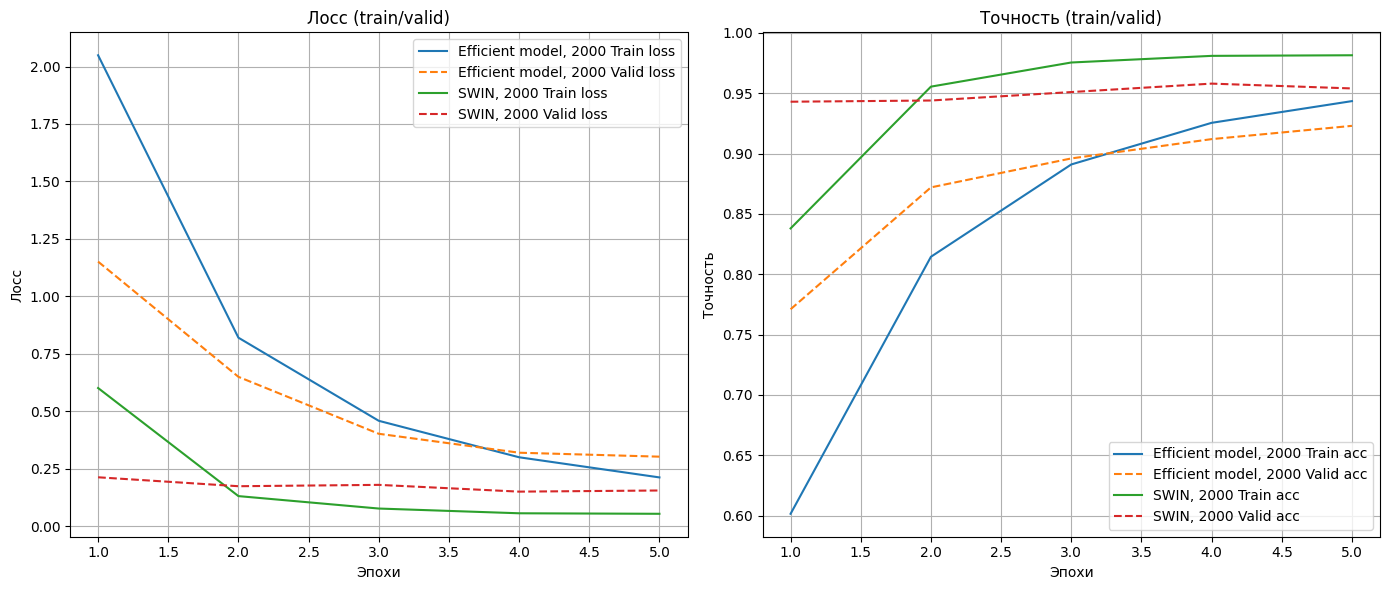

In [26]:
plot_metrics(["Efficient model, 2000", "SWIN, 2000"], [history_cnn_2000, history_swin_2000])

2) 8000 снимков.

In [33]:
train_loader, valid_loader = get_loaders(N=8000)

In [34]:
lr = 1e-4

efficient_model_8000 = EfficientNetForImageClassification.from_pretrained(
    "google/efficientnet-b0",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

optimizer = torch.optim.AdamW(efficient_model_8000.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([24, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([24]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
history_cnn_8000 = train_model(efficient_model_8000, 
                      train_loader,
                      valid_loader,
                      optimizer,
                      loss_fn,
                      num_epochs=2,
                      device="cuda",
                      developer_mode=False)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/2 - Train loss: 0.9464, Train acc: 0.7981 - Valid loss: 0.2375, Valid acc: 0.9440 - Time: 131.49 sec


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/2 - Train loss: 0.2225, Train acc: 0.9401 - Valid loss: 0.1618, Valid acc: 0.9600 - Time: 132.16 sec


In [36]:
lr = 1e-4

swin_model_8000 = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

optimizer = torch.optim.AdamW(swin_model_8000.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([24]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([24, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
history_swin_8000 = train_model(swin_model_8000, 
                      train_loader,
                      valid_loader,
                      optimizer,
                      loss_fn,
                      num_epochs=1,
                      device="cuda",
                      developer_mode=False)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 0.2484, Train acc: 0.9294 - Valid loss: 0.1168, Valid acc: 0.9580 - Time: 177.71 sec


In [39]:
# plot_metrics(["Efficient model, 8000", "SWIN, 8000"], [history_cnn_8000, history_swin_8000])

3) Все снимки

In [46]:
train_loader, valid_loader = get_loaders(N=styles_df.shape[0] - 1000)

In [47]:
lr = 1e-4

efficient_model_full = EfficientNetForImageClassification.from_pretrained(
    "google/efficientnet-b0",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

optimizer = torch.optim.AdamW(efficient_model_full.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([24, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([24]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
history_cnn_full = train_model(efficient_model_full, 
                      train_loader,
                      valid_loader,
                      optimizer,
                      loss_fn,
                      num_epochs=1,
                      device="cuda",
                      developer_mode=False)

  0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 0.5276, Train acc: 0.8787 - Valid loss: 0.1801, Valid acc: 0.9530 - Time: 299.43 sec


In [49]:
lr = 1e-4

swin_model_full = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

optimizer = torch.optim.AdamW(swin_model_full.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([24]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([24, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
history_swin_full = train_model(swin_model_full, 
                      train_loader,
                      valid_loader,
                      optimizer,
                      loss_fn,
                      num_epochs=1,
                      device="cuda",
                      developer_mode=False)

  0%|          | 0/586 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 0.2031, Train acc: 0.9404 - Valid loss: 0.1294, Valid acc: 0.9640 - Time: 394.73 sec


In [51]:
# plot_metrics(["Efficient model, Full", "SWIN, Full"], [history_cnn_full, history_swin_full])

### 3. Анализ моделей

1. Оцените размеры моделей (MB). Сравните время вычислений (сек.) и затрачиваемую память (MB) на обучении и на инференсе для обеих моделей.

In [52]:
def get_model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    size_all_bytes = param_size + buffer_size
    return size_all_bytes / (1024 ** 2)

def evaluate_performance(model, dataloader, loss_fn, device, mode="train", max_batches=10):
    model.to(device)
    model.eval() if mode == "eval" else model.train()
    
    start_time = time.time()
    torch.cuda.reset_peak_memory_stats(device)
    gc.collect()
    torch.cuda.empty_cache()

    total_loss = 0
    correct = 0
    total = 0

    optimizer = torch.optim.AdamW(model.parameters()) if mode == "train" else None

    with torch.set_grad_enabled(mode == "train"):
        for i, (images, labels) in enumerate(dataloader):
            if i >= max_batches:
                break

            images = images.to(device)
            labels = labels.to(device)

            if mode == "train":
                optimizer.zero_grad()
            
            outputs = model(images)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs
            loss = loss_fn(logits, labels)
            
            if mode == "train":
                loss.backward()
                optimizer.step()
            
            total_loss += loss.item() * images.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += torch.sum(preds == labels).item()
            total += images.size(0)

    end_time = time.time()
    time_sec = end_time - start_time
    peak_memory_mb = torch.cuda.max_memory_allocated(device) / 1024**2

    accuracy = correct / total
    avg_loss = total_loss / total

    return {
        "time_sec": time_sec,
        "peak_memory_mb": peak_memory_mb,
        "accuracy": accuracy,
        "avg_loss": avg_loss
    }

# === Собираем всё вместе ===

def evaluate_all_models(model_dict, train_loader, valid_loader, loss_fn, device="cuda"):
    results = []
    for name, model in model_dict.items():
        print(f"🔍 Evaluating {name}...")
        model_size = get_model_size_mb(model)

        train_metrics = evaluate_performance(model, train_loader, loss_fn, device, mode="train", max_batches=10)
        eval_metrics = evaluate_performance(model, valid_loader, loss_fn, device, mode="eval", max_batches=10)

        results.append({
            "Model": name,
            "Size_MB": round(model_size, 2),
            "Train_Time_s": round(train_metrics["time_sec"], 2),
            "Train_Memory_MB": round(train_metrics["peak_memory_mb"], 2),
            "Train_Accuracy": round(train_metrics["accuracy"], 4),
            "Eval_Time_s": round(eval_metrics["time_sec"], 2),
            "Eval_Memory_MB": round(eval_metrics["peak_memory_mb"], 2),
            "Eval_Accuracy": round(eval_metrics["accuracy"], 4)
        })
    return pd.DataFrame(results)

In [53]:
model_dict = {
    "EfficientNet 2000": efficient_model_2000,
    "Swin 2000": swin_model_2000,
    "EfficientNet 8000": efficient_model_8000,
    "Swin 8000": swin_model_8000,
    "EfficientNet full": efficient_model_full,
    "Swin full": swin_model_full
}

summary_df = evaluate_all_models(model_dict, train_loader, valid_loader, loss_fn, device="cuda")
summary_df

🔍 Evaluating EfficientNet 2000...
🔍 Evaluating Swin 2000...
🔍 Evaluating EfficientNet 8000...
🔍 Evaluating Swin 8000...
🔍 Evaluating EfficientNet full...
🔍 Evaluating Swin full...


Model  Size_MB  Train_Time_s  Train_Memory_MB  Train_Accuracy  \
0  EfficientNet 2000    15.57          9.09          6683.20          0.8750   
1          Swin 2000   331.43          9.99         10212.52          0.4188   
2  EfficientNet 8000    15.57          8.29          5646.28          0.8969   
3          Swin 8000   331.43          9.54         10220.77          0.3875   
4  EfficientNet full    15.57          8.56          5647.54          0.9219   
5          Swin full   331.43          9.55         10212.27          0.4000   

   Eval_Time_s  Eval_Memory_MB  Eval_Accuracy  
0         7.46         3283.39         0.8500  
1         8.03         3706.06         0.3125  
2         7.49         3279.76         0.8875  
3         8.22         3706.65         0.3125  
4         7.56         3280.42         0.9187  
5         8.28         3707.10         0.3125

Видим, что трансформер потребляет больше памяти.

Время на предсказания сопоставимо.


2. Выберите лучшие сверточную и трансформерную модели и проведите анализ ошибок моделей. 
- Определите, в каких классах ошибались модели.
- Визуализируйте примеры с правильными и неправильнымм предсказаниями для каждой модели.
- Предположите, с чем связаны ошибки.

In [54]:
best_cnn_index = np.argmax([
    history_cnn_2000["valid_acc"][-1],
    history_cnn_8000["valid_acc"][-1],
    history_cnn_full["valid_acc"][-1]
])
best_cnn_acc = np.max([
    history_cnn_2000["valid_acc"][-1],
    history_cnn_8000["valid_acc"][-1],
    history_cnn_full["valid_acc"][-1]
])

best_cnn_index, best_cnn_acc

(1, 0.96)

In [55]:
best_cnn = [efficient_model_2000, efficient_model_8000, efficient_model_full][best_cnn_index]

In [56]:
best_swin_index = np.argmax([
    history_swin_2000["valid_acc"][-1],
    history_swin_8000["valid_acc"][-1],
    history_swin_full["valid_acc"][-1]
])

best_swin_acc = np.max([
    history_swin_2000["valid_acc"][-1],
    history_swin_8000["valid_acc"][-1],
    history_swin_full["valid_acc"][-1]
])

best_swin_index, best_swin_acc

(2, 0.964)

In [57]:
best_swin = [swin_model_2000, swin_model_8000, swin_model_full][best_swin_index]

In [58]:
def analyze_model(model, dataloader, class_names, device="cuda", n_examples=5, mean=MEAN, std=STD):
    """
    Анализ модели с выводом гистограммы точности по классам
    
    Args:
        class_names: словарь {название_класса: номер_класса}
    """
    # Создаем обратное отображение
    num2name = {v: k for k, v in class_names.items()}
    valid_classes = set(num2name.keys())
    
    # Инициализация статистики
    stats = {name: {'total': 0, 'correct': 0} for name in class_names.keys()}
    
    model.to(device)
    model.eval()
    
    incorrect_samples = []
    correct_samples = []
    unknown_classes = set()

    # Сбор статистики
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Анализ модели"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs.logits if hasattr(outputs, "logits") else outputs, dim=1)
            
            for i in range(labels.size(0)):
                true_num = labels[i].item()
                pred_num = preds[i].item()
                
                if true_num not in valid_classes:
                    unknown_classes.add(true_num)
                    continue
                
                true_name = num2name[true_num]
                stats[true_name]['total'] += 1
                
                if true_num == pred_num:
                    stats[true_name]['correct'] += 1
                    if len(correct_samples) < n_examples:
                        correct_samples.append((images[i].cpu(), true_num, pred_num))
                else:
                    if len(incorrect_samples) < n_examples:
                        incorrect_samples.append((images[i].cpu(), true_num, pred_num))

    # Подготовка данных для гистограммы
    class_names_list = []
    accuracies = []
    counts = []
    
    for class_name in class_names.keys():
        if stats[class_name]['total'] > 0:
            accuracy = stats[class_name]['correct'] / stats[class_name]['total'] * 100
            class_names_list.append(class_name)
            accuracies.append(accuracy)
            counts.append(stats[class_name]['total'])

    # Визуализация гистограммы
    if class_names_list:
        plt.figure(figsize=(12, 6))
        bars = plt.bar(class_names_list, accuracies)
        
        # Добавляем аннотации с количеством примеров
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{count} ex',
                    ha='center', va='bottom')
        
        plt.title('Точность по классам')
        plt.ylabel('Точность (%)')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 110)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # Вывод информации о неизвестных классах
    if unknown_classes:
        print(f"\nОбнаружены неизвестные классы: {unknown_classes}")

    # Визуализация примеров
    def visualize(samples, title):
        if not samples:
            return
            
        fig, axes = plt.subplots(1, min(n_examples, len(samples)), figsize=(15, 4))
        for ax, (img, true_num, pred_num) in zip(axes, samples):
            if mean and std:
                img = denormalize(img, mean, std)
            ax.imshow(img.permute(1, 2, 0).numpy().clip(0, 1))
            ax.set_title(f"True: {num2name[true_num]}\nPred: {num2name.get(pred_num, 'UNKNOWN')}")
            ax.axis('off')
        plt.suptitle(title)
        plt.show()
    
    visualize(incorrect_samples, "Примеры с ошибками")
    visualize(correct_samples, "Примеры правильных предсказаний")

    # Оформление статистики в DataFrame и вывод
    if class_names_list:
        data = {
            'Класс': class_names_list,
            'Точность': np.round(accuracies, 1),
            'Правильно': [int(acc * count / 100) for acc, count in zip(accuracies, counts)],
            'Всего': counts
        }
        df = pd.DataFrame(data)
        display(df)

Efficient Net

Анализ модели:   0%|          | 0/32 [00:00<?, ?it/s]

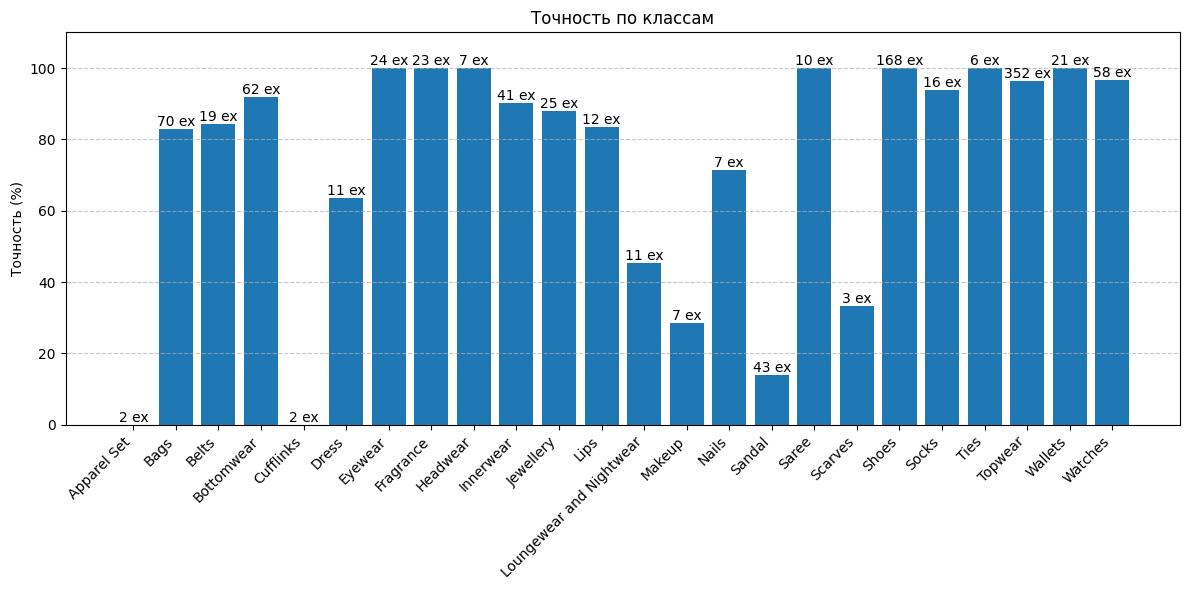

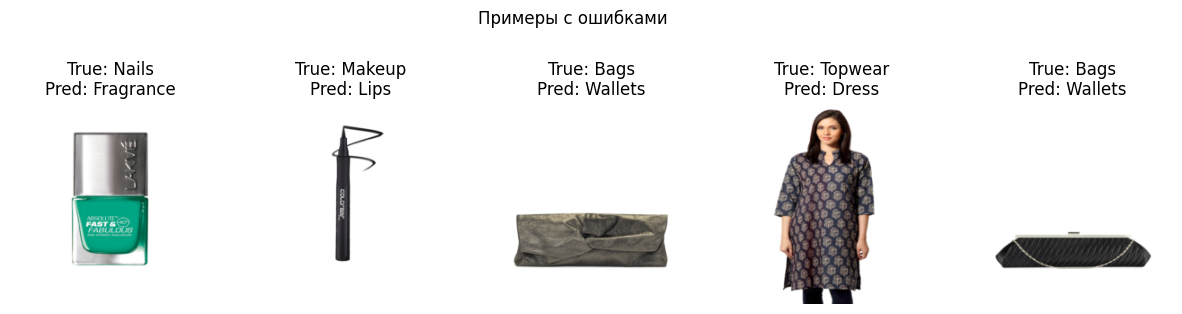

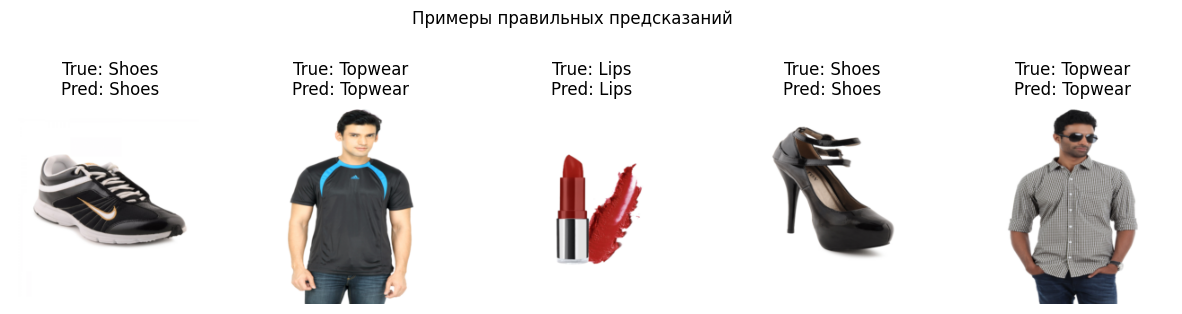

Класс  Точность  Правильно  Всего
0                Apparel Set       0.0          0      2
1                       Bags      82.9         58     70
2                      Belts      84.2         15     19
3                 Bottomwear      91.9         57     62
4                  Cufflinks       0.0          0      2
5                      Dress      63.6          7     11
6                    Eyewear     100.0         24     24
7                  Fragrance     100.0         23     23
8                   Headwear     100.0          7      7
9                  Innerwear      90.2         37     41
10                 Jewellery      88.0         22     25
11                      Lips      83.3         10     12
12  Loungewear and Nightwear      45.5          5     11
13                    Makeup      28.6          2      7
14                     Nails      71.4          5      7
15                    Sandal      14.0          6     43
16                     Saree     100.0         10     10
17                   Scarves      33.3          0      3
18                     Shoes     100.0        168    168
19                     Socks      93.8         15     16
20                      Ties     100.0          6      6
21                   Topwear      96.3        339    352
22                   Wallets     100.0         21     21
23                   Watches      96.6         56     58

In [59]:
analyze_model(best_cnn, valid_loader, label2class, device="cuda")

SWIN

Анализ модели:   0%|          | 0/32 [00:00<?, ?it/s]

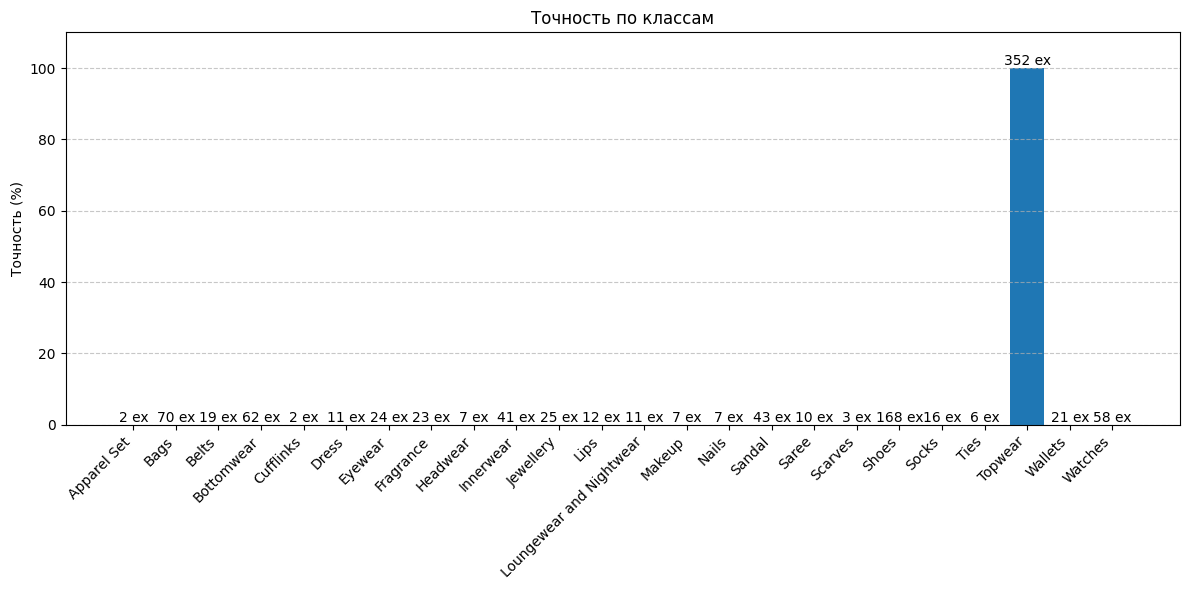

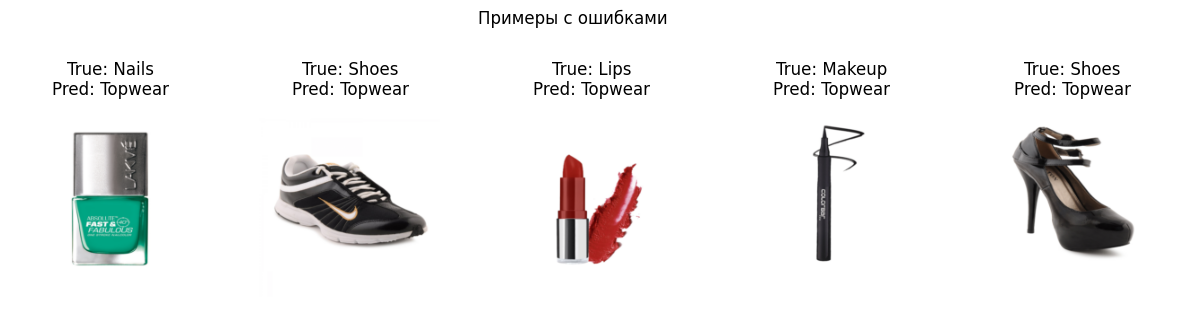

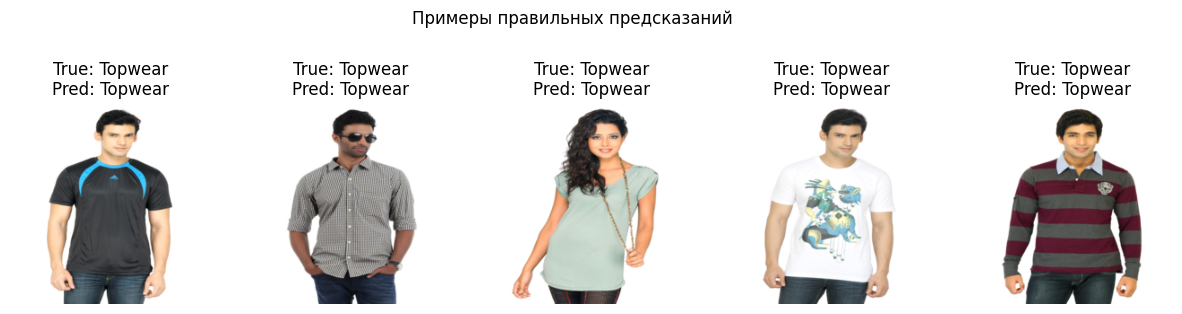

Класс  Точность  Правильно  Всего
0                Apparel Set       0.0          0      2
1                       Bags       0.0          0     70
2                      Belts       0.0          0     19
3                 Bottomwear       0.0          0     62
4                  Cufflinks       0.0          0      2
5                      Dress       0.0          0     11
6                    Eyewear       0.0          0     24
7                  Fragrance       0.0          0     23
8                   Headwear       0.0          0      7
9                  Innerwear       0.0          0     41
10                 Jewellery       0.0          0     25
11                      Lips       0.0          0     12
12  Loungewear and Nightwear       0.0          0     11
13                    Makeup       0.0          0      7
14                     Nails       0.0          0      7
15                    Sandal       0.0          0     43
16                     Saree       0.0          0     10
17                   Scarves       0.0          0      3
18                     Shoes       0.0          0    168
19                     Socks       0.0          0     16
20                      Ties       0.0          0      6
21                   Topwear     100.0        352    352
22                   Wallets       0.0          0     21
23                   Watches       0.0          0     58

In [60]:
analyze_model(best_swin, valid_loader, label2class, device="cuda")

3. Сделайте **выводы** по задаче.

* В задаче мы убедились, что трансформеры выигрывают у сверток

* Заметим, что трансформер обучается дольше, чем сверточная нейронная сеть

* Время на инференсе у моделей примерно одинаковое.

## Задача 2 &mdash; Attention vs. Outlook attention

Реализуйте классы 1 блока Attention и 1 блока Outlook attention.

Примените написанные слои к случайному тензору или произвольной картинке. Сравните:
* время вычислений (сек)
* затрачиваемую память (MB)


In [61]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.FFN = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)

        inp_x = self.layer_norm_1(x)
        x = x + self.self_attn(inp_x, inp_x, inp_x)[0]
        x = x + self.FFN(self.layer_norm_2(x))
        
        x = x.transpose(1, 2).reshape(B, C, H, W)
        return x


In [62]:
class OutlookAttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, window_size, dropout=0.0):
        super().__init__()
        self.window_size = window_size
        
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        
        self.FFN = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )
    
    def forward(self, x):
        B, C, H, W = x.shape
        
        x_norm = self.layer_norm_1(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        
        patches = F.unfold(x_norm, kernel_size=self.window_size, stride=self.window_size)
        num_windows = patches.shape[-1]
        patches = patches.view(B, C, self.window_size * self.window_size, num_windows)
        patches = patches.permute(2, 0, 3, 1).contiguous().view(self.window_size * self.window_size, B * num_windows, C)
        
        attn_out = self.self_attn(patches, patches, patches)[0]
        
        patches = patches + attn_out
        patches = patches.view(self.window_size * self.window_size, B, num_windows, C)
        patches = patches.permute(1, 3, 0, 2).contiguous()
        patches = patches.view(B, C * self.window_size * self.window_size, num_windows)

        x_attn = F.fold(patches, output_size=(H, W), kernel_size=self.window_size, stride=self.window_size)
        
        x_attn_norm = self.layer_norm_2(x_attn.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        ffn_out = self.FFN(x_attn_norm.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

        x_out = x_attn + ffn_out
        return x_out

In [63]:
import torch.nn.functional as F

def measure_time(model, x, num_iter=10):
    start_time = time.time()
    
    # Прогрев
    for _ in range(10):
        _ = model(x)
    
    torch.cuda.synchronize() if device.type == "cuda" else None
    
    for _ in range(num_iter):
        _ = model(x)
    
    torch.cuda.synchronize() if device.type == "cuda" else None
    end_time = time.time()
    
    return (end_time - start_time) / num_iter

def measure_memory(model, x, num_iter=10):
    torch.cuda.reset_peak_memory_stats() if device.type == "cuda" else None
    
    # Прогрев
    for _ in range(10):
        _ = model(x)
    
    torch.cuda.synchronize() if device.type == "cuda" else None
    
    torch.cuda.reset_peak_memory_stats() if device.type == "cuda" else None
    for _ in range(num_iter):
        _ = model(x)
    
    torch.cuda.synchronize() if device.type == "cuda" else None
    memory_allocated = torch.cuda.max_memory_allocated() if device.type == "cuda" else 0
    
    return memory_allocated / (1024 ** 2)  

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_attention = torch.randn(1, 64, 56, 56).to(device)
x_outlook = torch.randn(1, 64, 56, 56).to(device)

embed_dim = 64
hidden_dim = 128
num_heads = 8
window_size = 7

attention_block = AttentionBlock(embed_dim, hidden_dim, num_heads).to(device)
outlook_block = OutlookAttentionBlock(embed_dim, hidden_dim, num_heads, window_size).to(device)

time_attention = measure_time(attention_block, x_attention)
print(f"Average time for AttentionBlock: {time_attention:.6f} seconds")

memory_attention = measure_memory(attention_block, x_attention)
print(f"Peak memory for AttentionBlock: {memory_attention:.2f} MB")

time_outlook = measure_time(outlook_block, x_outlook)
print(f"Average time for OutlookAttentionBlock: {time_outlook:.6f} seconds")

memory_outlook = measure_memory(outlook_block, x_outlook)
print(f"Peak memory for OutlookAttentionBlock: {memory_outlook:.2f} MB")

Average time for AttentionBlock: 0.004927 seconds
Peak memory for AttentionBlock: 2867.94 MB
Average time for OutlookAttentionBlock: 0.003748 seconds
Peak memory for OutlookAttentionBlock: 2874.83 MB


Сделайте **выводы** по задаче.

Как видим, время для attention блока более чем в два раза превышает outlook attention, а затраченное время сопоставимо.